In [1]:
from glob import glob
from subprocess import run
import os

In [11]:
os.chdir('/data/MSciObjDetNew/images')

In [3]:
cluster_folders = glob('*/')

In [4]:
bands = ['814', '606', '435']
bandlabels = ['I', 'V', 'B']
zeropoints = [25.947, 26.493, 25.665]

SExtractor parameters are chosen to err on side of overblending.

In [6]:
for cf in cluster_folders:
    print(cf)
    os.chdir(cf)
    images = [glob('*{}*drz.fits'.format(band))[0] for band in bands]
    cmdtemplate = ('sex -c ../sex.config -CATALOG_NAME {cluster}-{band}-sex.fits '
                   '-WEIGHT_IMAGE {detwimg},{wimg} '
                   '-ZEROPOINT {zp} '
                   '-CHECKIMAGE_NAME {cluster}-{band}-seg.fits '
                   '{detimg} {img}')
    for i, b in enumerate(bands):
        cmd = cmdtemplate.format(cluster=cf[:-1], band=b,
                                 zp=zeropoints[i],
                                 detimg=images[0],
                                 img=images[i],
                                 detwimg=images[0].replace('drz', 'wht'),
                                 wimg=images[i].replace('drz', 'wht'))
        print(cmd)
        run(cmd, shell=True)
    os.chdir('..')

macs0416par/
sex -c ../sex.config -CATALOG_NAME macs0416par-814-sex.fits -WEIGHT_IMAGE hlsp_frontier_hst_acs-30mas-selfcal_macs0416-hffpar_f814w_v1.0-epoch2_wht.fits,hlsp_frontier_hst_acs-30mas-selfcal_macs0416-hffpar_f814w_v1.0-epoch2_wht.fits -ZEROPOINT 25.947 -CHECKIMAGE_NAME macs0416par-814-seg.fits hlsp_frontier_hst_acs-30mas-selfcal_macs0416-hffpar_f814w_v1.0-epoch2_drz.fits hlsp_frontier_hst_acs-30mas-selfcal_macs0416-hffpar_f814w_v1.0-epoch2_drz.fits
sex -c ../sex.config -CATALOG_NAME macs0416par-606-sex.fits -WEIGHT_IMAGE hlsp_frontier_hst_acs-30mas-selfcal_macs0416-hffpar_f814w_v1.0-epoch2_wht.fits,hlsp_frontier_hst_acs-30mas-selfcal_macs0416-hffpar_f606w_v1.0-epoch2_wht.fits -ZEROPOINT 26.493 -CHECKIMAGE_NAME macs0416par-606-seg.fits hlsp_frontier_hst_acs-30mas-selfcal_macs0416-hffpar_f814w_v1.0-epoch2_drz.fits hlsp_frontier_hst_acs-30mas-selfcal_macs0416-hffpar_f606w_v1.0-epoch2_drz.fits
sex -c ../sex.config -CATALOG_NAME macs0416par-435-sex.fits -WEIGHT_IMAGE hlsp_frontier

sex -c ../sex.config -CATALOG_NAME abells1063par-435-sex.fits -WEIGHT_IMAGE hlsp_frontier_hst_acs-30mas-selfcal_abells1063-hffpar_f814w_v1.0-epoch2_wht.fits,hlsp_frontier_hst_acs-30mas-selfcal_abells1063-hffpar_f435w_v1.0-epoch2_wht.fits -ZEROPOINT 25.665 -CHECKIMAGE_NAME abells1063par-435-seg.fits hlsp_frontier_hst_acs-30mas-selfcal_abells1063-hffpar_f814w_v1.0-epoch2_drz.fits hlsp_frontier_hst_acs-30mas-selfcal_abells1063-hffpar_f435w_v1.0-epoch2_drz.fits
abell2744/
sex -c ../sex.config -CATALOG_NAME abell2744-814-sex.fits -WEIGHT_IMAGE hlsp_frontier_hst_acs-30mas-selfcal_abell2744_f814w_v1.0-epoch2_wht.fits,hlsp_frontier_hst_acs-30mas-selfcal_abell2744_f814w_v1.0-epoch2_wht.fits -ZEROPOINT 25.947 -CHECKIMAGE_NAME abell2744-814-seg.fits hlsp_frontier_hst_acs-30mas-selfcal_abell2744_f814w_v1.0-epoch2_drz.fits hlsp_frontier_hst_acs-30mas-selfcal_abell2744_f814w_v1.0-epoch2_drz.fits
sex -c ../sex.config -CATALOG_NAME abell2744-606-sex.fits -WEIGHT_IMAGE hlsp_frontier_hst_acs-30mas-selfc

In [7]:
import astropy.table as tab
from astropy.table import Table

In [8]:
os.chdir('..')

In [13]:
sexcats = {}
for cf in cluster_folders:
    os.chdir(cf)
    sexcat = None
    for i, b in enumerate(bands):
        cat = Table.read('{cluster}-{band}-sex.fits'.format(cluster=cf[:-1], band=b))
        if i == 0:
            cat['R50'] = cat['FLUX_RADIUS'][:,2]
            cat['CONC8020'] = cat['FLUX_RADIUS'][:,1] / cat['FLUX_RADIUS'][:,3]
            cat['CONC9050'] = cat['FLUX_RADIUS'][:,0] / cat['FLUX_RADIUS'][:,2]
        cat.remove_column('FLUX_RADIUS')
        if i > 0:
            cat.remove_columns(['THETA_IMAGE', 'ELLIPTICITY'])
        cat.rename_column('MAG_AUTO', 'MAG_{}'.format(bandlabels[i]))
        if sexcat is None:
            sexcat = cat
        else:
            sexcat = tab.join(cat, sexcat, keys='NUMBER')

    sexcat['BV'] = sexcat['MAG_B'] - sexcat['MAG_V']
    bad = (sexcat['MAG_B'] > 98) | (sexcat['MAG_V'] > 98)
    sexcat['BV'][bad] = 99

    sexcat['VI'] = sexcat['MAG_V'] - sexcat['MAG_I']
    bad = (sexcat['MAG_V'] > 98) | (sexcat['MAG_I'] > 98)
    sexcat['VI'][bad] = 99    
    os.chdir('..')
    sexcats[cf[:-1]] = sexcat


/home/ppzsb1/software/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/home/ppzsb1/software/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


In [14]:
%matplotlib inline
from matplotlib import pyplot as plt

In [15]:
def histplot(x, name, xlim, ax):
    ax.hist(x, bins=100, histtype='stepfilled', alpha=0.5);
    med = np.median(x)
    ax.set_title('median = {:.2f}'.format(med))
    ax.vlines(med, *ax.get_ylim())
    ax.set_xlabel(name)
    ax.set_xlim(*xlim)

/home/ppzsb1/software/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/home/ppzsb1/software/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


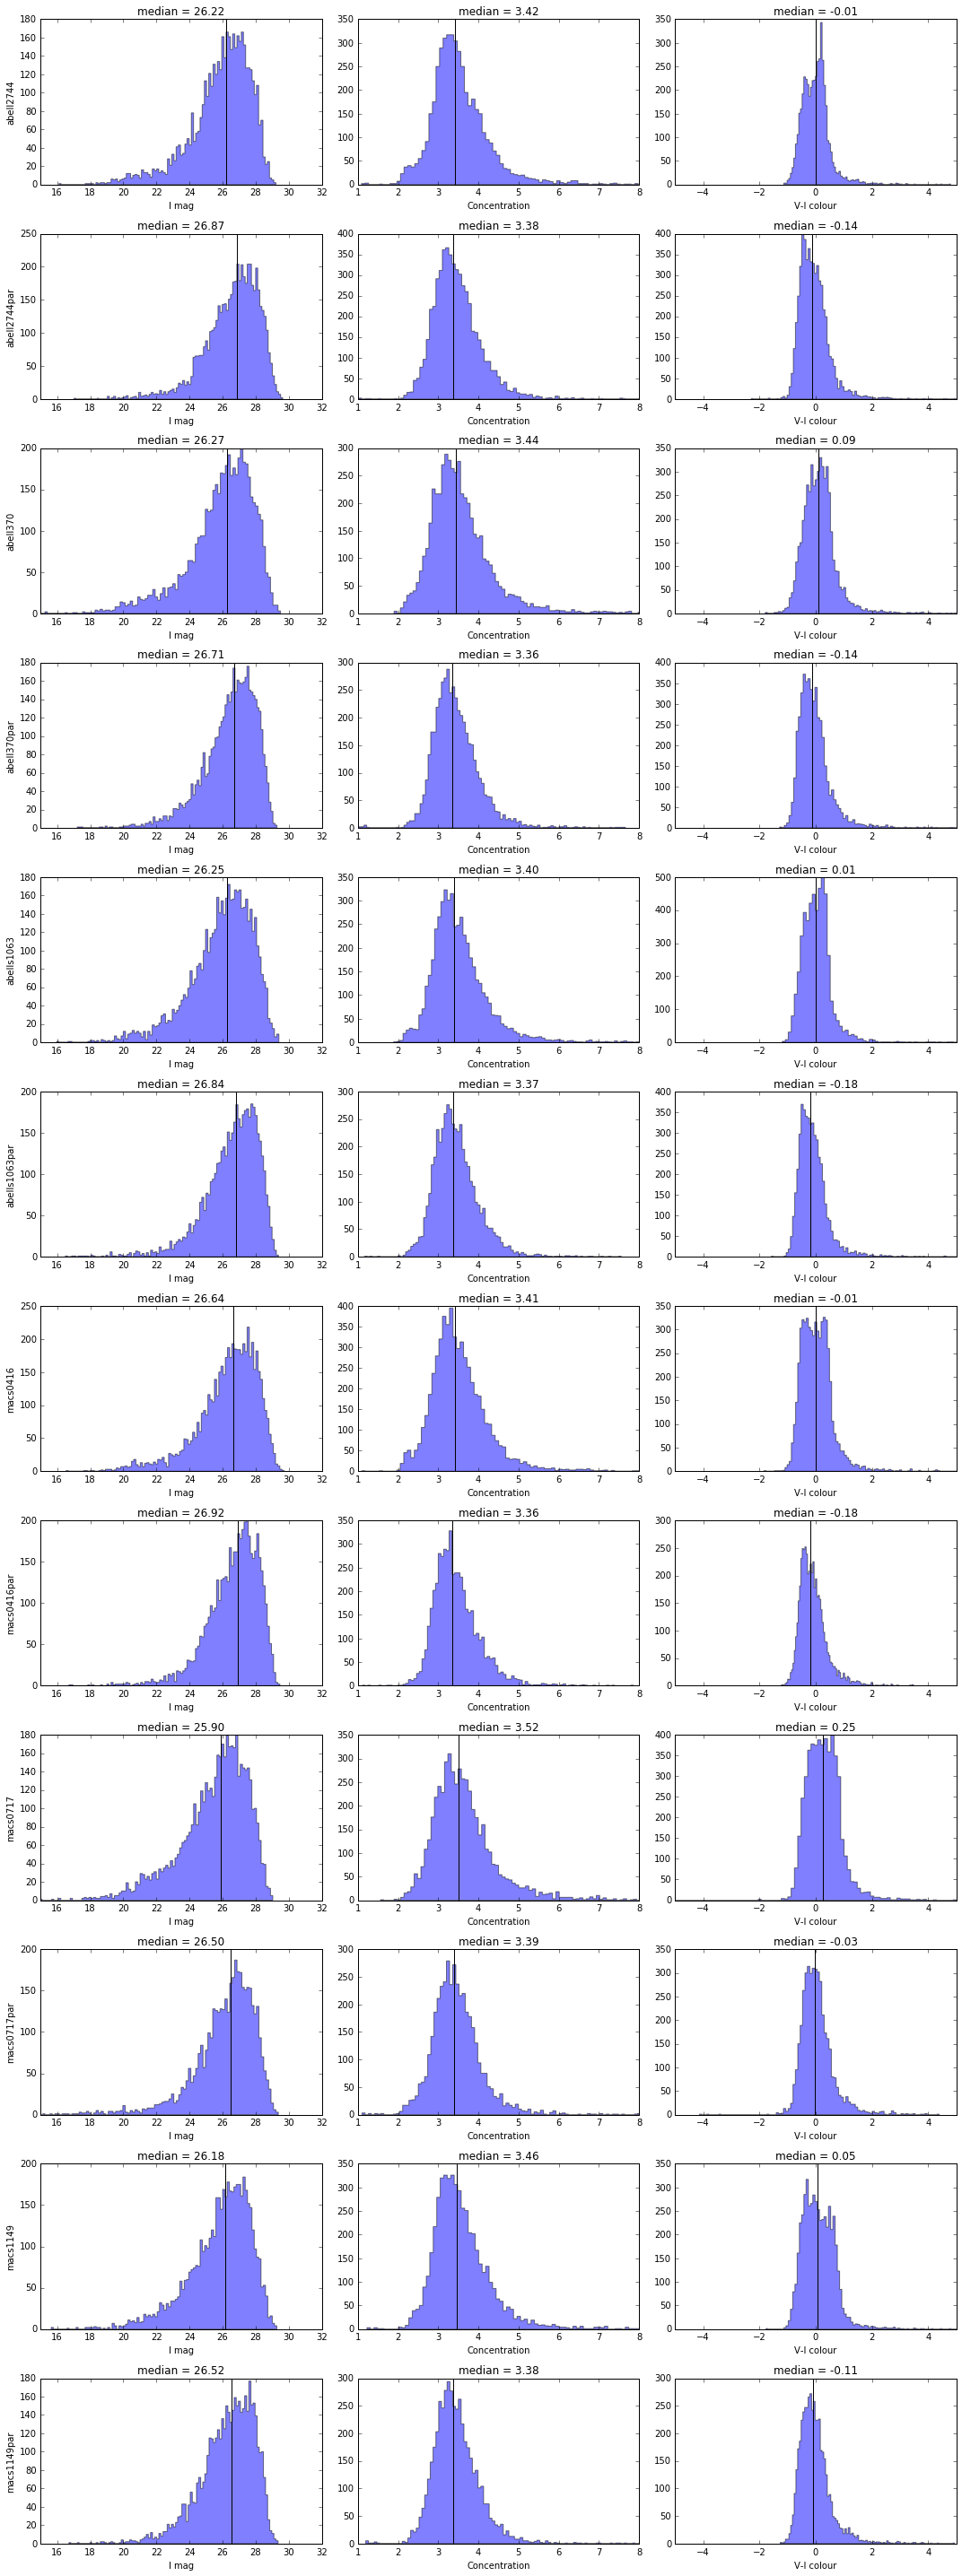

In [17]:
fig, axarr = plt.subplots(12, 3, figsize=(15, 40))
for j, cluster in enumerate(sorted(sexcats.keys())):
    sexcat = sexcats[cluster]
    magi = sexcat['MAG_I']
    conc8020 = sexcat['CONC8020']
    vi = sexcat['VI']
    ok = (magi > -98) & (magi < 98) & (conc8020 > 0) & (conc8020 < 10) & (vi > -98) & (vi < 98)
    magi = magi[ok]
    conc8020 = conc8020[ok]
    vi = vi[ok]
    variables = {'I mag': (magi, (15, 32)),
                 'Concentration': (conc8020, (1, 8)),
                 'V-I colour': (vi, (-5, 5))}
    for i, (name, (x, limits)) in enumerate(variables.items()):
        histplot(x, name, limits, axarr[j, i])
        if i == 0:
            axarr[j, i].set_ylabel(cluster)
plt.tight_layout()

In [18]:
for j, cluster in enumerate(sorted(sexcats.keys())):
    sexcat = sexcats[cluster]
    magi = sexcat['MAG_I']
    ok = (magi > 10) & (magi < 32)
    mag_faint = ok & (magi > 27)
    mag_medium = ok & (magi <= 27) & (magi > 25)
    mag_bright = ok & (magi <= 25)
    sexcat['mag_class'] = 0  # uncertain
    sexcat['mag_class'][mag_faint] = 1
    sexcat['mag_class'][mag_medium] = 2
    sexcat['mag_class'][mag_bright] = 3
    
    conc8020 = sexcat['CONC8020']
    ok = (conc8020 > 1) & (conc8020 < 10)
    conc_low = ok & (conc8020 < 3.5)
    conc_high = ok & (conc8020 >= 3.5)
    sexcat['conc_class'] = 0  # uncertain
    sexcat['conc_class'][conc_low] = 1
    sexcat['conc_class'][conc_high] = 2

    vi = sexcat['VI']
    ok = (vi > -5) & (vi < 10)
    vi_blue = ok & (vi < 0.0)
    vi_red = ok & (vi >= 0.0)
    sexcat['colour_class'] = 0  # uncertain
    sexcat['colour_class'][vi_blue] = 1
    sexcat['colour_class'][vi_red] = 2

/home/ppzsb1/software/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/home/ppzsb1/software/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less
/home/ppzsb1/software/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/home/ppzsb1/software/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater_equal


In [19]:
sexcats

{'abell2744': <Table length=4706>
 NUMBER  MAG_B   MAG_V   MAG_I  ...     VI    mag_class conc_class colour_class
          mag     mag     mag   ...    mag                                     
 int32  float32 float32 float32 ...  float32    int64     int64       int64    
 ------ ------- ------- ------- ... --------- --------- ---------- ------------
      1 21.6383 19.0037 18.6849 ...  0.318819         3          2            2
      2 25.2631 22.7251 22.1031 ...  0.621977         3          2            2
      3 22.4568 19.7707 19.3829 ...  0.387812         3          2            2
      4 26.2073 24.2826 23.9082 ...  0.374424         3          1            2
      5   26.28 24.9491 24.5112 ...  0.437977         3          1            2
      6 26.6942 26.0815 25.4712 ...  0.610266         2          1            2
      7 26.6589 25.8351 25.0193 ...  0.815811         2          1            2
      8 26.5993 25.8753 25.2154 ...  0.659922         2          1            2
      

In [25]:
mastersexcat = None
for j, cluster in enumerate(sorted(sexcats.keys())):
    os.chdir(cf)
    sexcat = sexcats[cluster]
    #sexcat.write('{}-sex.fits'.format(cluster))
    os.chdir('..')
    sexcat['field'] = cluster
    if mastersexcat is None:
        mastersexcat = sexcat
    else:
        mastersexcat = tab.vstack([mastersexcat, sexcat])
        
mastersexcat.write('mastersex.fits'.format(cluster))